# Assignment 10: New New Analysis

In [1]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import norm
import seaborn as sns

## Part 1: Group analysis

### 0. Setup

In [2]:
np.random.seed(12345678)  # for reproducibility, set random seed

# Read in data
df = pd.read_csv('../output.csv')

nvox = 64*64*48 # assume number of voxels per bin
df['weighted'] = df['synapses']/df['unmasked']*nvox

xvals = df['cx'].unique()
yvals = df['cy'].unique()
zvals = df['cz'].unique()

# Get rid of the blank edges
left = 0;
right = len(xvals);
top = 0;
bottom = len(yvals);
for z in zvals:
    this_z = df[df['cz']==z]
    
    # X direction
    xhist, bin_edges = np.histogram(this_z['cx'], weights = this_z['unmasked']/(nvox*len(yvals)), bins=len(xvals))
    
    left = max(left, np.argmax(xhist>0.5))
    right = min(right, len(xvals)-np.argmax(xhist[::-1]>0.5))
    
    # Y direction
    yhist, bin_edges = np.histogram(this_z['cy'], weights = this_z['unmasked']/(nvox*len(xvals)), bins=len(yvals))
    
    top = max(top, np.argmax(yhist>0.5))
    bottom = min(bottom, len(yvals)-np.argmax(yhist[::-1]>0.5))

# Copy new dataset without edges
df2 = df.copy()
for z in zvals:
    df2.drop(df2.index[(df2['cx']<xvals[left]) | (df2['cx']>=xvals[right])], inplace=True)
    df2.drop(df2.index[(df2['cy']<yvals[top]) | (df2['cy']>=yvals[bottom])], inplace=True)
print "There are", len(df2), "bins after removing the edges."

xvals = df2['cx'].unique()
yvals = df2['cy'].unique()
zvals = df2['cz'].unique()

There are 35112 bins after removing the edges.


### 1. Plot Y-layer density distribution

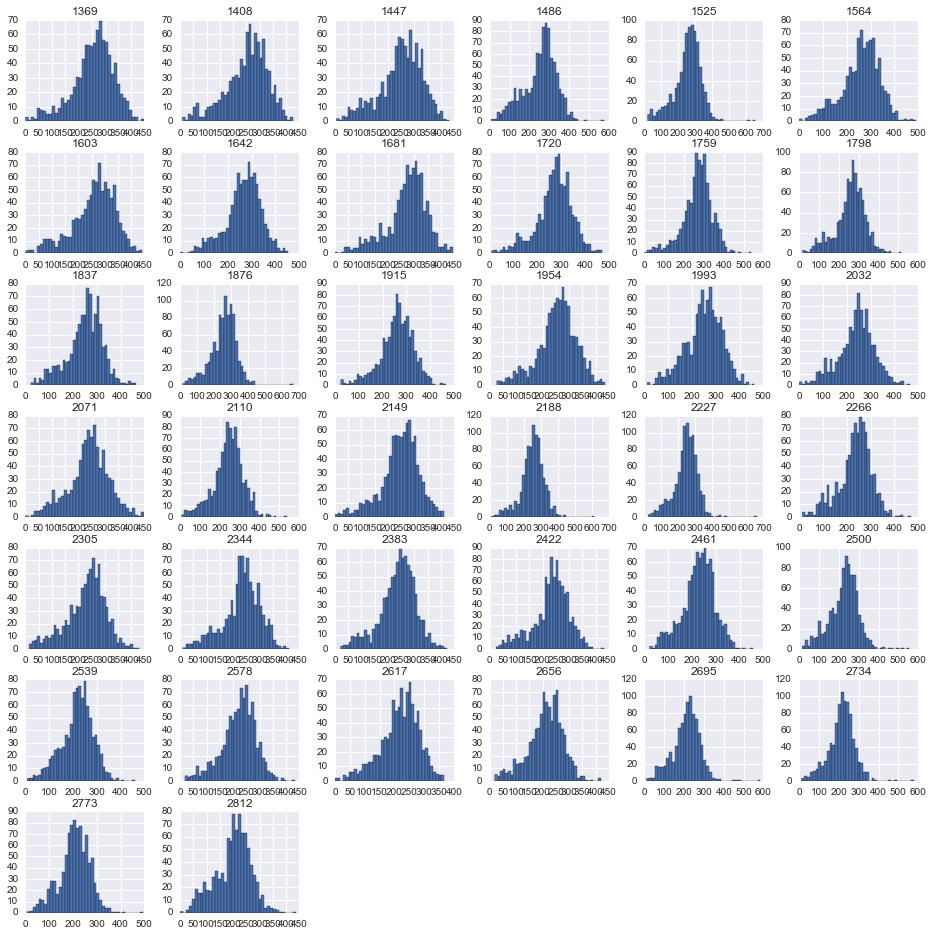

In [3]:
byY = pd.pivot_table(df2, index=['cx','cz'], columns='cy', values='weighted', aggfunc=np.sum)
byY.hist(bins=40, figsize=(16,16))

Divide Y-layers into four groups arbitrarily.

In [12]:
ygroups = np.array([0]*10+[1]*9+[2]*10+[3]*9)

df2['ygroup'] = 0
for y, ygrp in zip(yvals, ygroups):
    df2.loc[df2['cy']==y, 'ygroup'] = ygrp

df2.head()

,cx,cy,cz,unmasked,synapses,weighted,ygroup
6292,448,1369,55,126357,153,238.063772,0
6293,448,1369,166,139932,207,290.840237,0
6294,448,1369,277,150269,194,253.824488,0
6295,448,1369,388,138071,159,226.410122,0
6296,448,1369,499,150842,258,336.278119,0


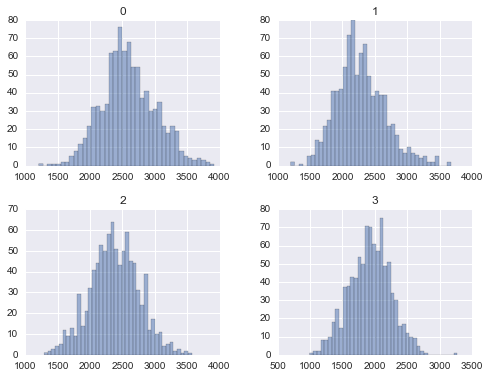

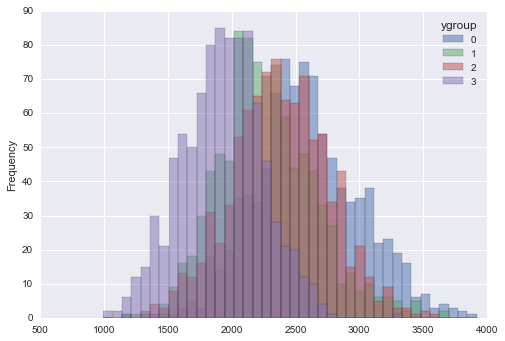

In [23]:
byYgrp = pd.pivot_table(df2, index=['cx','cz'], columns='ygroup', values='weighted', aggfunc=np.sum)

byYgrp.hist(alpha=0.5, bins=40, figsize=(8,6));
plt.show()

byYgrp.plot.hist(alpha=0.5, bins=40);
plt.show()

### 2. Test for Normal Distribution in Y-layer groups

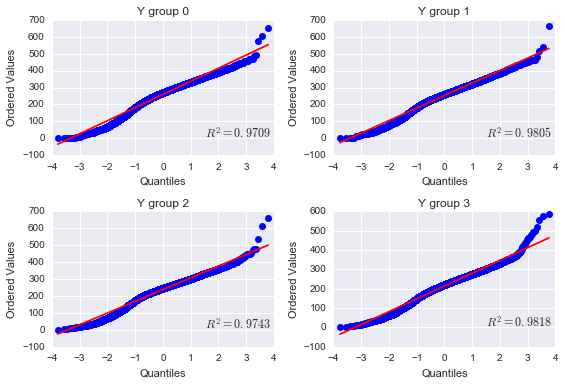

In [36]:
plt.figure()
for i in range(4):
    plt.subplot(221+i)
    ss.probplot(df2[df2['ygroup']==i]['weighted'], plot = plt)
    plt.title('Y group '+str(i))
plt.tight_layout()
plt.show()

The distribution of synapse densities in the Y groups appears close to normal.

### 3. Rank-sum test for difference in Y-layer group means

In [39]:
for i in range(4):
    for j in range(i+1,4):
        stat, p = ss.ranksums(df2[df2['ygroup']==i]['weighted'], df2[df2['ygroup']==j]['weighted'])
        print "Difference in means between group", i, "and group", j, ": W =", stat, ", p =", p

Difference in means between group 0 and group 1 : W = 7.78425986509 , p = 7.01224946287e-15
Difference in means between group 0 and group 2 : W = 22.7987743125 , p = 4.71532470432e-115
Difference in means between group 0 and group 3 : W = 43.8806094709 , p = 0.0
Difference in means between group 1 and group 2 : W = 14.6859833474 , p = 7.92757551668e-49
Difference in means between group 1 and group 3 : W = 37.1732225897 , p = 1.84846735384e-302
Difference in means between group 2 and group 3 : W = 25.4920297374 , p = 2.41618072244e-143


### 4. Test different numbers of clusters for K-means

### 5. Classification using 3D cubes
* Use 1/2 Y layers for training, 1/2 for testing